# Train a Custom Deep Model for CCS Prediction
Say you come up with your very own idea for a deep CCS predictor architecture and want to build on top of ionmob.
It is recomended that you have a NVIDIA CUDA enabled GPU with cuDNN bianries available in your working environment,
otherwise training may take quite some time.
We  will assume that a dataset for training was already generated, including all necesarry steps for preprocessing.
For this demonstration, we can use ionmob dataset. 
Let's use sets from different sources for training, validation and test.
This way, we make sure that we do not overestimate model performace.
We will start our model implementation by fitting a tokenizer.

In [1]:
import os
# suppress CUDA logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime

gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

from matplotlib import pyplot as plt
from ionmob.alignment.experiment import Experiment

from ionmob.models.deep_models import ProjectToInitialSqrtCCS, DeepRecurrentModel
from ionmob.preprocess.data import get_tf_dataset, partition_tf_dataset, to_tf_dataset
from ionmob.preprocess.helpers import get_sqrt_slopes_and_intercepts, sequence_to_tokens, fit_tokenizer
from ionmob.preprocess.helpers import tokenizer_to_json, tokenizer_from_json
from ionmob.preprocess.tokenization import get_index_dict, get_occurring_kmers, create_count_vectors

data_train = pd.read_parquet('../../notebook/data/unimod/Meier_unimod.parquet')
data_valid = pd.read_parquet('../../notebook/data/unimod/Tenzer_unique_unimod.parquet')
data_phos = pd.read_parquet('../../notebook/data/unimod/Tenzer-phospho-train_unimod.parquet')
data_test = pd.read_parquet('../../notebook/data/unimod/Chang_unique_unimod.parquet')

data_train = pd.concat([data_train, data_phos])

tokenizer = tokenizer_from_json('../pretrained-models/tokenizers/tokenizer.json')

print(tokenizer.word_index)

{'L': 1, 'E': 2, 'S': 3, 'A': 4, 'V': 5, 'D': 6, 'G': 7, '<END>': 8, 'P': 9, '<START>': 10, 'T': 11, 'I': 12, 'Q': 13, 'K': 14, 'N': 15, 'R': 16, 'F': 17, 'H': 18, 'Y': 19, 'M[UNIMOD:35]': 20, 'C[UNIMOD:4]': 21, 'M': 22, 'W': 23, 'S[UNIMOD:21]': 24, '<START>[UNIMOD:1]': 25, 'T[UNIMOD:21]': 26, 'Y[UNIMOD:21]': 27, 'K[UNIMOD:1]': 28, 'C[UNIMOD:312]': 29, 'C': 30}


In [9]:
data_train

,mz,charge,sequence-tokenized,ccs,rt,name
0,695.373655,2,"[<START>, L, F, S, L, T, P, A, E, V, E, Q, R, ...",399.424316,31.618,meier_test
1,579.638442,3,"[<START>, I, I, F, I, D, T, E, N, T, F, R, P, ...",533.304565,31.503,meier_test
2,883.397530,2,"[<START>, Y, D, G, Y, T, S, C[UNIMOD:4], P, L,...",436.513153,2855.300,meier_train
3,786.851040,2,"[<START>[UNIMOD:1], M, E, E, S, G, Y, E, S, V,...",447.272522,92.878,meier_train
4,748.722288,3,"[<START>, V, L, A, S, S, L, N, S, L, P, D, F, ...",599.993652,105.420,meier_train
...,...,...,...,...,...,...
55456,728.259000,3,"[<START>, E, L, V, S[UNIMOD:21], S, S[UNIMOD:2...",534.128279,17.920,Tenzer-phospho-yeast-ttp
55457,592.573700,3,"[<START>, S, H, S, G, S, S[UNIMOD:21], S, P, S...",468.586429,7.380,Tenzer-phospho-yeast-ttp
55458,728.259500,3,"[<START>, E, L, V, S, S, S[UNIMOD:21], S, S, G...",518.288007,17.390,Tenzer-phospho-yeast-ttp
55459,478.558800,3,"[<START>, S[UNIMOD:21], R, S, D, S, P, P, R, Q...",473.585129,5.570,Tenzer-phospho-yeast-ttp


The tokenizer now knows 30 tokens, 20 AAs, \<START>, \<STOP> and 8 PTMs. Next, we generate tensorflow datasets.

In [2]:
tf_train = to_tf_dataset(data_train.mz, data_train.charge, [list(x) for x in data_train['sequence-tokenized']], 
                          data_train.ccs, tokenizer, batch=False).shuffle(int(1e7)).batch(1024)

tf_valid = to_tf_dataset(data_valid.mz, data_valid.charge, [list(x) for x in data_valid['sequence-tokenized']], 
                          data_valid.ccs, tokenizer, batch=False).shuffle(int(1e7)).batch(1024)

tf_test = to_tf_dataset(data_test.mz, data_test.charge, [list(x) for x in data_test['sequence-tokenized']], 
                          data_test.ccs, tokenizer, batch=False).batch(1024)

It has proved to be a very efficient way to build on top of a simple sqrt-fit to help a deep predictor reach high accuracy  as well as fast convergence. 
Ionmob implements its own layer that is able to project all charge states at the same time, making it very convenient to add it to your own predictor.
It is done in two steps: first, fit slopes and intercepts for the initial prediction separately. 
Second, use the gained values to initialize a initial projection layer.
Ionmob makes use of charge state one-hot encoding to gate the prediction based on a given charge state.
If you are interested in the intrinsics, have a look at the implementation.

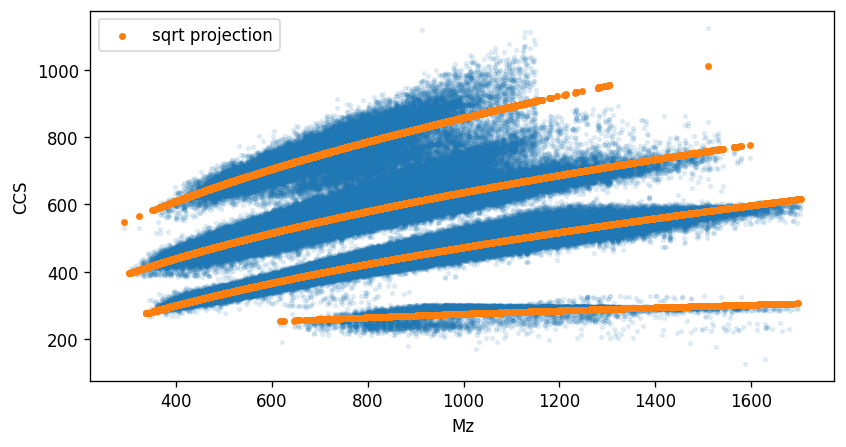

In [3]:
slopes, intercepts = get_sqrt_slopes_and_intercepts(data_train.mz, data_train.charge, 
                                                    data_train.ccs, fit_charge_state_one=True)

initial_layer = ProjectToInitialSqrtCCS(slopes, intercepts)

# just make sure that everything worked by testing the projection
initial_ccs = initial_layer([np.expand_dims(data_train.mz, 1), tf.one_hot(data_train.charge - 1, 4)]).numpy()

# visualize to make sure all went as intended
plt.figure(figsize=(8, 4), dpi=120)
plt.scatter(data_train.mz, data_train.ccs, s=5, alpha=.1)
plt.scatter(data_train.mz, initial_ccs, s=10, label='sqrt projection')
plt.xlabel('Mz')
plt.ylabel('CCS')
plt.legend()
plt.show()

The most flexible way to implement a new predictor is to subclass a tensorflow module or keras model. 
We will do the latter, as it is the prominent way to generate new predictors for ionmob. 
Let's set up a predictor that uses 1-D convolutions to extract additional information from the sequence of an ion. 
All layers that should be part of the model are defined in the constructor, the execution is defined by specifying the call method.

In [4]:
class ConvolutionalCCSPredictor(tf.keras.models.Model):
    
    def __init__(self, slopes, intercepts, num_tokens=44, seq_len=50):
        super(ConvolutionalCCSPredictor, self).__init__()
        # the inital sqrt projection
        self.initial = ProjectToInitialSqrtCCS(slopes, intercepts)
        
        # the deep sequence processor
        self.embedding = tf.keras.layers.Embedding(input_dim=num_tokens + 1, output_dim=128, input_length=seq_len)
        self.conv1d = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')
        self.mp1d = tf.keras.layers.MaxPool1D(pool_size=2)
        self.conv1d_2 = tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu')
        
        # the deep regression tail
        self.dense = tf.keras.layers.Dense(128, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.dense_2 = tf.keras.layers.Dense(64, activation='relu')
        self.out = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        # read inputs
        mz, charge, sequence = inputs
        
        # calculate sequence part
        deep = self.conv1d_2(self.mp1d(self.conv1d(self.embedding(sequence))))
        
        # concat with mz and charge
        concat = tf.keras.layers.Concatenate()([tf.keras.layers.Flatten()(deep), tf.sqrt(mz), charge])
        
        # deep regression
        dense = self.dense_2(self.dropout(self.dense(concat)))
        
        # output is sqrt-fit + deep-regression
        return self.initial([mz, charge]) + self.out(dense)

Callbacks are a convenient way to further automate your training procedure. 
We will use two different callbacks that observe model performance on validation data.
The first one is a learning rate reducer: Should the loss not go down after three consecutive epochs on the validation set, the reducer is going to reduce the learning rate by an order of magnitude. f there is still no improvement on performance, the early stopper will stop the training procedure after another 2 epochs.

In [5]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=1e-1,
    patience=2,
    monde='auto',
    min_delta=1e-5,
    cooldown=0,
    min_lr=1e-7
)

cbs = [early_stopper, reduce_lr]

We are now ready to instanciate our predictor, build it and then compile it with a desired objective function and optimizer. 
The models' summary tells us that it has a total of 178,785 trainable parameters.

In [6]:
# create a recurrent predictor
model = ConvolutionalCCSPredictor(slopes, intercepts)

# set input shapes: mz, charge_one_hot, max_seq_len, helix_score, gravy_score
model.build([(None, 1), (None, 4), (None, 50)])

model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=tf.keras.optimizers.Adam(1e-2), metrics=['mae'])

print(model.summary())

Model: "convolutional_ccs_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 project_to_initial_sqrt_ccs  multiple                 0         
 _1 (ProjectToInitialSqrtCCS                                     
 )                                                               
                                                                 
 embedding (Embedding)       multiple                  5760      
                                                                 
 conv1d (Conv1D)             multiple                  32800     
                                                                 
 max_pooling1d (MaxPooling1D  multiple                 0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           multiple                  16448     
                                       

In [7]:
history = model.fit(tf_train, validation_data=tf_valid, 
                    epochs=50, verbose=True, callbacks=cbs)

# plot training and validation loss 
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Epoch 1/50
763/763 [==============================] - 12s 9ms/step - loss: 10.3293 - mae: 10.3293 - val_loss: 11.1114 - val_mae: 11.1114 - lr: 0.0100
Epoch 2/50
763/763 [==============================] - 8s 8ms/step - loss: 9.4621 - mae: 9.4621 - val_loss: 11.0120 - val_mae: 11.0120 - lr: 0.0100
Epoch 3/50
763/763 [==============================] - 8s 8ms/step - loss: 9.2371 - mae: 9.2371 - val_loss: 10.9760 - val_mae: 10.9760 - lr: 0.0100
Epoch 4/50
763/763 [==============================] - 8s 9ms/step - loss: 9.0810 - mae: 9.0810 - val_loss: 10.9810 - val_mae: 10.9810 - lr: 0.0100
Epoch 5/50
763/763 [==============================] - 8s 8ms/step - loss: 9.0062 - mae: 9.0062 - val_loss: 11.1330 - val_mae: 11.1330 - lr: 0.0100
Epoch 6/50


KeyboardInterrupt: 

In [8]:
model.evaluate(tf_test)

4/4 [==============================] - 0s 20ms/step - loss: 11.8703 - mae: 11.8703


[11.870251655578613, 11.870251655578613]